**PlantSnap** — ResNet34

In [1]:
!pip install -q tqdm scikit-learn matplotlib seaborn pillow

# imports
import os
import random
import time
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms, datasets, models

from sklearn.metrics import classification_report, confusion_matrix
import itertools


In [2]:
# seeds and device
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # flags for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# dataset path & constants
DATA_DIR = "/content/drive/MyDrive/ds_xs_f"  # <-- change to your dataset path after uploading

# structure
expected_subdirs = ["train", "test"]
print("Listing dataset root:", DATA_DIR)
print(os.listdir(DATA_DIR)[:50])

# training configuration
IMG_SIZE = 160
BATCH_SIZE = 16
NUM_CLASSES = 13
NUM_EPOCHS = 10      # 5 head + 5 fine-tune
PATIENCE = 3

Listing dataset root: /content/drive/MyDrive/ds_xs_f
['.DS_Store', 'train', 'test']


In [5]:
# class mapping
CLASS_MAP = {
    "bacterial_leaf_blight": "Bacterial Leaf Blight (BLB)",
    "bacterial_leaf_streak": "Bacterial Leaf Streak (BLS)",
    "bacterial_panicle_blight": "Bacterial Panicle Blight (BPB)",
    "black_stem_borer": "Black Stem Borer (BSB)",
    "blast": "Blast",
    "brown_spot": "Brown Spot",
    "downy_mildew": "Downy Mildew",
    "hispa": "Hispa",
    "leaf_roller": "Leaf Roller",
    "normal": "Normal",
    "tungro": "Tungro",
    "white_stem_borer": "White Stem Borer",
    "yellow_stem_borer": "Yellow Stem Borer"
}
# ordered list of class folder names
class_folders = list(CLASS_MAP.keys())
print("Classes:", class_folders)

Classes: ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'black_stem_borer', 'blast', 'brown_spot', 'downy_mildew', 'hispa', 'leaf_roller', 'normal', 'tungro', 'white_stem_borer', 'yellow_stem_borer']


In [6]:
# transforms, dataset, dataloaders
train_dir = os.path.join(DATA_DIR, "train")
test_dir = os.path.join(DATA_DIR, "test")

# transforms
mean = [0.485, 0.456, 0.406]  # imageNet
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])


full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)

# dataset with val transforms but same samples using Subset
full_train_dataset_for_split = datasets.ImageFolder(root=train_dir, transform=val_test_transform)

test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)


print("dataset classes:", full_train_dataset.classes)
print("num train images:", len(full_train_dataset))
print("num test images:", len(test_dataset))

# split train -> train/val (80/20)
train_len = int(0.8 * len(full_train_dataset))
val_len = len(full_train_dataset) - train_len
train_dataset, val_dataset = random_split(full_train_dataset, [train_len, val_len], generator=torch.Generator().manual_seed(SEED))

train_indices = train_dataset.indices
val_indices = val_dataset.indices

train_dataset = Subset(datasets.ImageFolder(root=train_dir, transform=train_transform), train_indices)
val_dataset = Subset(datasets.ImageFolder(root=train_dir, transform=val_test_transform), val_indices)

print("train size:", len(train_dataset), "val size:", len(val_dataset))

# dataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


dataset classes: ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'black_stem_borer', 'blast', 'brown_spot', 'downy_mildew', 'hispa', 'leaf_roller', 'normal', 'tungro', 'white_stem_borer', 'yellow_stem_borer']
num train images: 260
num test images: 65
train size: 208 val size: 52


In [7]:
# model (ResNet34)
# pretrained ResNet34 w replaced fc
def create_model(num_classes=NUM_CLASSES, pretrained=True):
    model = models.resnet34(pretrained=pretrained)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

model = create_model().to(device)
print(model)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

print("optimizer & scheduler set.")

optimizer & scheduler set.


In [9]:
# training & val functions
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Train batches"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data).item()
        total += inputs.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    return epoch_loss, epoch_acc

def eval_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Eval batches"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            probs = torch.softmax(outputs, dim=1)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).item()
            total += inputs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_probs), np.array(all_labels)


In [10]:
# training loop
best_val_acc = 0.0
best_model_wts = None
epochs_no_improve = 0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

save_dir = "/content/drive/MyDrive/plantsnap_resnet34"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _, _ = eval_model(model, val_loader, criterion, device)
    scheduler.step()

    print(f"Train loss: {train_loss:.4f} acc: {train_acc:.4f}")
    print(f"Val   loss: {val_loss:.4f} acc: {val_acc:.4f}")

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # checkpoint
    if val_acc > best_val_acc + 1e-6:
        best_val_acc = val_acc
        best_model_wts = model.state_dict()
        torch.save(best_model_wts, os.path.join(save_dir, "resnet34_paddy_best_state_dict.pth"))
        print("saved best model weights.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"no improvement for {epochs_no_improve} epochs.")

    # early stopping
    if epochs_no_improve >= PATIENCE:
        print("early stopping triggered.")
        break

# best weights
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)
    print("loaded best model weights.")
else:
    print("no best model saved; using last epoch weights.")



Epoch 1/10


Train batches:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Eval batches: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Train loss: 2.8591 acc: 0.1106
Val   loss: 3.0705 acc: 0.1346
saved best model weights.

Epoch 2/10


Eval batches: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Train loss: 2.9650 acc: 0.1923
Val   loss: 3.5276 acc: 0.1154
no improvement for 1 epochs.

Epoch 3/10


Eval batches: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Train loss: 3.1009 acc: 0.2308
Val   loss: 2.6480 acc: 0.0962
no improvement for 2 epochs.

Epoch 4/10


Eval batches: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Train loss: 3.1848 acc: 0.2115
Val   loss: 3.9933 acc: 0.1538
saved best model weights.

Epoch 5/10


Eval batches: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Train loss: 2.6766 acc: 0.1923
Val   loss: 4.9418 acc: 0.1346
no improvement for 1 epochs.

Epoch 6/10


Eval batches: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


Train loss: 2.2659 acc: 0.2740
Val   loss: 2.7286 acc: 0.2500
saved best model weights.

Epoch 7/10


Eval batches: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Train loss: 1.7938 acc: 0.4038
Val   loss: 2.2801 acc: 0.2692
saved best model weights.

Epoch 8/10


Eval batches: 100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


Train loss: 1.5196 acc: 0.4904
Val   loss: 2.2176 acc: 0.3269
saved best model weights.

Epoch 9/10


Eval batches: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Train loss: 1.3585 acc: 0.5240
Val   loss: 2.1557 acc: 0.4038
saved best model weights.

Epoch 10/10


Eval batches: 100%|██████████| 4/4 [00:04<00:00,  1.25s/it]

Train loss: 1.2305 acc: 0.5817
Val   loss: 2.2875 acc: 0.3654
no improvement for 1 epochs.
loaded best model weights.


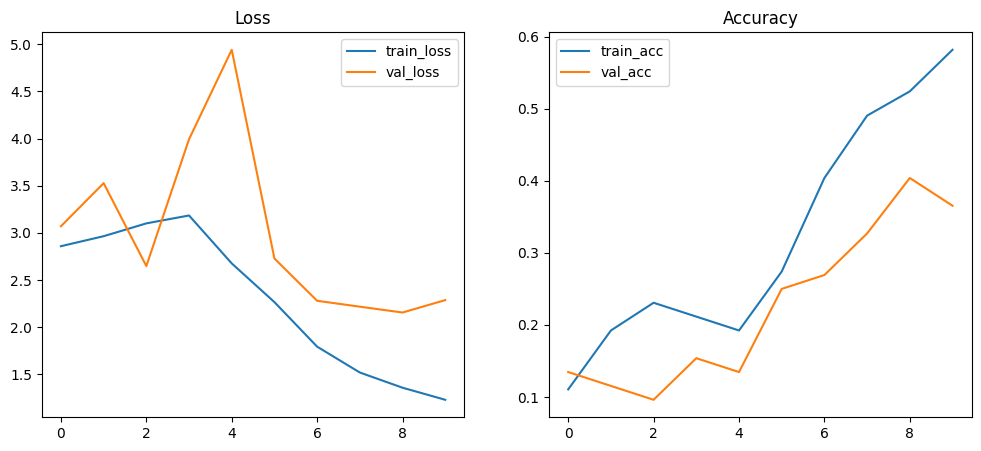

In [11]:
# plot training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.legend(); plt.title("Accuracy")
plt.show()


Eval batches: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]



Test loss: 1.7484  Test acc: 0.5385

Classification report:
                                precision    recall  f1-score   support

   Bacterial Leaf Blight (BLB)     1.0000    0.2000    0.3333         5
   Bacterial Leaf Streak (BLS)     0.3333    0.2000    0.2500         5
Bacterial Panicle Blight (BPB)     1.0000    0.4000    0.5714         5
        Black Stem Borer (BSB)     0.8333    1.0000    0.9091         5
                         Blast     0.2857    0.4000    0.3333         5
                    Brown Spot     0.4286    0.6000    0.5000         5
                  Downy Mildew     0.2500    0.4000    0.3077         5
                         Hispa     0.3333    0.4000    0.3636         5
                   Leaf Roller     0.4286    0.6000    0.5000         5
                        Normal     1.0000    0.2000    0.3333         5
                        Tungro     0.8000    0.8000    0.8000         5
              White Stem Borer     0.8000    0.8000    0.8000         5
  

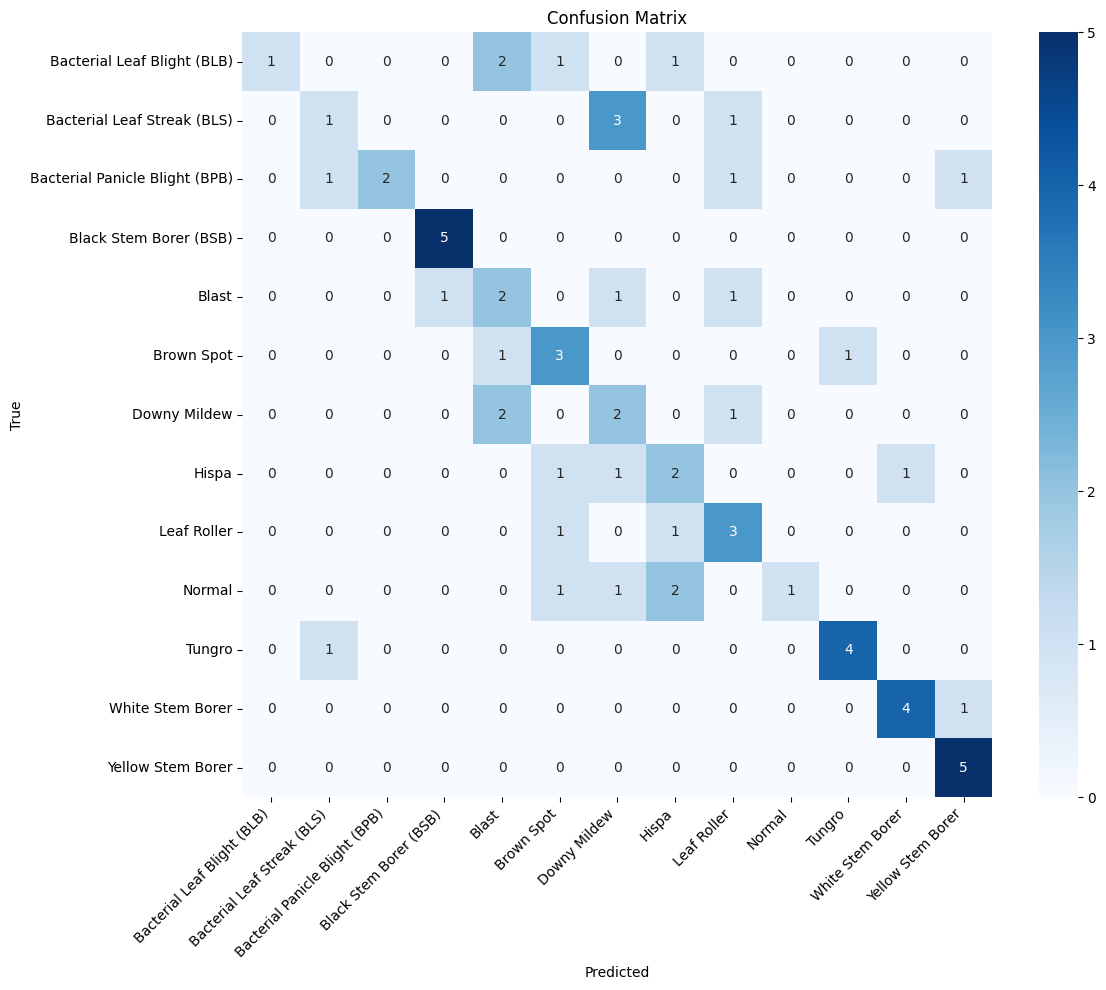

In [12]:
# evaluate on test set
test_loss, test_acc, test_preds, test_probs, test_labels = eval_model(model, test_loader, criterion, device)
print(f"\nTest loss: {test_loss:.4f}  Test acc: {test_acc:.4f}")

idx_to_class = {v: k for k, v in full_train_dataset.class_to_idx.items()}

display_names = [CLASS_MAP[idx_to_class[i]] for i in range(len(idx_to_class))]

print("\nClassification report:")
print(classification_report(test_labels, test_preds, target_names=display_names, digits=4))

# confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=display_names, yticklabels=display_names, cmap="Blues")
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [50]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

IMG_SIZE = 224  #input size

# Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(grad):
            self.gradients = grad.detach()

        #  activations
        self.target_layer.register_forward_hook(forward_hook)

        # gradients using hook on the output tensor
        def wrapper_hook(module, input, output):
            output.register_hook(backward_hook)

        self.target_layer.register_forward_hook(wrapper_hook)

    def __call__(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        loss = output[0, class_idx]
        loss.backward(retain_graph=True)

        # compute CAM
        pooled_grads = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        weighted_activations = self.activations * pooled_grads
        cam = weighted_activations.sum(dim=1, keepdim=True)
        cam = torch.clamp(cam, min=0)
        cam = cam.squeeze().cpu().numpy()

        # normalize CAM
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))

        return cam


# overlay CAM on image
def show_cam_on_image(img_pil, cam, alpha=0.5):
    img = np.array(img_pil.convert('RGB')) / 255.0
    h, w, _ = img.shape
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.resize(heatmap, (w, h))
    heatmap = np.float32(heatmap) / 255.0
    overlay = heatmap * alpha + img
    overlay = overlay / np.max(overlay)
    plt.imshow(overlay)
    plt.axis('off')


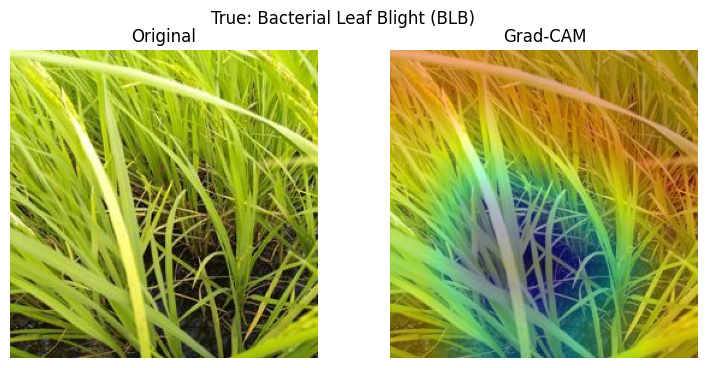

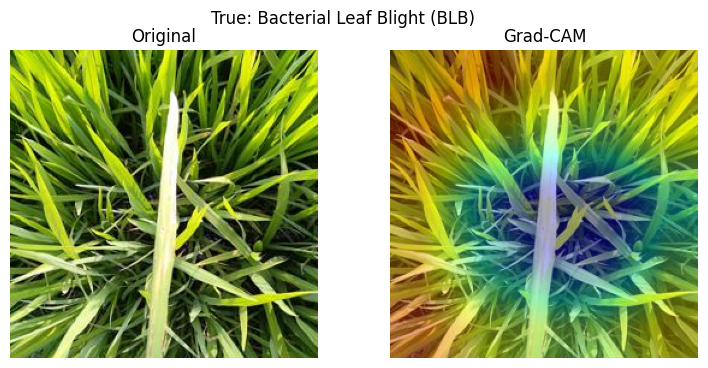

In [51]:
# model to device
model.to(device)
model.eval()

# GradCAM on layer4
grad_cam = GradCAM(model, model.layer4)

# sample images with Grad-CAM
n_samples = 2
samples_shown = 0

for i in range(len(test_dataset)):
    if samples_shown >= n_samples:
        break

    img, label = test_dataset[i]
    inp = img.unsqueeze(0).to(device)

    cam = grad_cam(inp)

    # Load original image using PIL
    img_pil = Image.open(test_dataset.samples[i][0]).convert('RGB')

    plt.figure(figsize=(9, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_pil)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    show_cam_on_image(img_pil, cam)
    plt.title("Grad-CAM")
    plt.axis('off')

    plt.suptitle(f"True: {display_names[label]}")
    samples_shown += 1

plt.show()


In [17]:

save_dir = "/content/drive/MyDrive/plantsnap_resnet34"
os.makedirs(save_dir, exist_ok=True)

# clean model (no Grad-CAM hooks)
clean_model = models.resnet34(weights=None)  # or weights="IMAGENET1K_V1" if you want
num_ftrs = clean_model.fc.in_features
clean_model.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)

# state_dict
state_dict_path = os.path.join(save_dir, "plantSnap_res34_state_dict.pth")
clean_model.load_state_dict(torch.load(state_dict_path, map_location="cpu"))

# eval and cpu
clean_model = clean_model.to("cpu")
clean_model.eval()

torch.save(clean_model.state_dict(), os.path.join(save_dir, "plantSnap_res34_state_dict_clean.pth"))

# torchScript tracing
example_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)
traced_script_module = torch.jit.trace(clean_model, example_input)
traced_script_module.save(os.path.join(save_dir, "plantSnap_res34_ts.pt"))

print("state_dict & TorchScript model saved at:", save_dir)


state_dict & TorchScript model saved at: /content/drive/MyDrive/plantsnap_resnet34


In [60]:
rule_based = {
    "Bacterial Leaf Blight (ব্যাকটেরিয়াল লিফ ব্লাইট - BLB)": {
        "summary_en": "BLB is a bacterial disease causing water-soaked lesions that enlarge and turn yellow or brown.",
        "summary_bn": "বিএলবি একটি ব্যাকটেরিয়াজনিত রোগ যা পানিভেজা দাগ সৃষ্টি করে যা পরে বড় হয়ে হলুদ বা বাদামী রঙ ধারণ করে।",
        "recommendation_en": "Use resistant varieties, avoid early high nitrogen, apply copper-based bactericides as recommended by agricultural extension. Improve drainage and avoid overhead irrigation.",
        "recommendation_bn": "প্রতিরোধী জাত ব্যবহার করুন, শুরুর দিকে উচ্চ মাত্রায় নাইট্রোজেন প্রয়োগ এড়িয়ে চলুন, কৃষি সম্প্রসারণ অধিদপ্তরের পরামর্শ অনুযায়ী তামা-ভিত্তিক ব্যাকটেরিসাইড ব্যবহার করুন। পানি নিষ্কাশন উন্নত করুন এবং উপরি সেচ পরিহার করুন।",
        "references": [
            "IRRI - Rice Knowledge Bank: Bacterial Leaf Blight",
            "FAO / National Agricultural Extension Recommendations"
        ]
    },
    "Bacterial Leaf Streak (ব্যাকটেরিয়াল লিফ স্ট্রিক - BLS)": {
        "summary_en": "BLS causes narrow, elongated water-soaked streaks on leaves.",
        "summary_bn": "বিএলএস পাতায় সরু, লম্বা ও পানিভেজা দাগ সৃষ্টি করে।",
        "recommendation_en": "Use certified seed, practice crop rotation, remove infected residues, and follow chemical control guidelines from local extension services.",
        "recommendation_bn": "প্রমাণিত বীজ ব্যবহার করুন, ফসল পর্যায় পরিবর্তন করুন, আক্রান্ত অবশিষ্টাংশ সরিয়ে ফেলুন এবং স্থানীয় সম্প্রসারণ অধিদপ্তরের রাসায়নিক ব্যবস্থাপনা নির্দেশিকা অনুসরণ করুন।",
        "references": ["IRRI / FAO resources"]
    },
    "Bacterial Panicle Blight (ব্যাকটেরিয়াল প্যানিকল ব্লাইট - BPB)": {
        "summary_en": "BPB affects panicles causing discoloration and sterility.",
        "summary_bn": "বিপিবি শীষে আক্রমণ করে, যার ফলে বিবর্ণতা এবং বন্ধ্যত্ব দেখা দেয়।",
        "recommendation_en": "Adjust planting dates, use resistant varieties, and consult extension services for management practices.",
        "recommendation_bn": "রোপণের সময় ঠিক করুন, প্রতিরোধী জাত ব্যবহার করুন এবং ব্যবস্থাপনার জন্য কৃষি সম্প্রসারণ থেকে পরামর্শ নিন।",
        "references": ["IRRI / Local Extension Publications"]
    },
    "Black Stem Borer (ব্ল্যাক স্টেম বোরার - BSB)": {
        "summary_en": "Black stem borer damages stems, causing deadhearts or whiteheads.",
        "summary_bn": "ব্ল্যাক স্টেম বোরার গাছের কাণ্ডে আক্রমণ করে, যার ফলে ডেডহার্ট বা হোয়াইটহেড দেখা দেয়।",
        "recommendation_en": "Apply integrated pest management (IPM): biological control, threshold-based insecticide use, and resistant varieties.",
        "recommendation_bn": "সমন্বিত পোকা দমন পদ্ধতি (IPM) ব্যবহার করুন: জৈবিক দমন, নির্ধারিত মাত্রায় কীটনাশক প্রয়োগ এবং প্রতিরোধী জাত ব্যবহার করুন।",
        "references": ["IRRI - Stem Borers", "Local Extension Papers"]
    },
    "Blast (ব্লাস্ট)": {
        "summary_en": "Rice blast causes diamond-shaped lesions with gray centers on leaves.",
        "summary_bn": "ব্লাস্ট রোগ পাতায় ধূসর কেন্দ্রবিশিষ্ট হীরার মতো আকৃতির দাগ সৃষ্টি করে।",
        "recommendation_en": "Use resistant cultivars, avoid dense planting, manage nitrogen levels, and apply fungicides as per guidance.",
        "recommendation_bn": "প্রতিরোধী জাত ব্যবহার করুন, ঘন রোপণ এড়িয়ে চলুন, নাইট্রোজেন ব্যবস্থাপনা করুন এবং নির্দেশনা অনুযায়ী ছত্রাকনাশক প্রয়োগ করুন।",
        "references": ["IRRI - Rice Blast Pages"]
    },
    "Brown Spot (ব্রাউন স্পট)": {
        "summary_en": "Brown spot causes small, round lesions often due to nutrient deficiencies like potassium or silicon.",
        "summary_bn": "ব্রাউন স্পট রোগে সাধারণত পটাশিয়াম বা সিলিকনের ঘাটতির কারণে ছোট গোল দাগ দেখা যায়।",
        "recommendation_en": "Improve soil fertility, use balanced fertilizer, and apply fungicides if recommended.",
        "recommendation_bn": "মাটির উর্বরতা বাড়ান, সুষম সার ব্যবহার করুন এবং প্রয়োজনে ছত্রাকনাশক ব্যবহার করুন।",
        "references": ["IRRI / FAO Publications"]
    },
    "Downy Mildew (ডাউনি মিলডিউ)": {
        "summary_en": "Downy mildew causes yellow patches and fuzzy fungal growth under the leaf surface.",
        "summary_bn": "ডাউনি মিলডিউ পাতার নিচে হলুদ দাগ এবং ছত্রাকের ঝাঁঝালো বৃদ্ধি ঘটায়।",
        "recommendation_en": "Use certified seeds, control humidity, adjust sowing dates, and apply foliar fungicides if needed.",
        "recommendation_bn": "প্রমাণিত বীজ ব্যবহার করুন, আর্দ্রতা নিয়ন্ত্রণ করুন, বপনের সময় ঠিক করুন এবং প্রয়োজনে ছত্রাকনাশক প্রয়োগ করুন।",
        "references": ["IRRI / Extension Guidance"]
    },
    "Hispa (হিসপা)": {
        "summary_en": "Hispa beetle scrapes the leaf surface causing silvery patches.",
        "summary_bn": "হিসপা পোকা পাতার উপরিভাগ চেঁছে রূপালি দাগ সৃষ্টি করে।",
        "recommendation_en": "Use IPM: monitor regularly, conserve natural predators, and apply insecticides if thresholds are exceeded.",
        "recommendation_bn": "IPM অনুসরণ করুন: নিয়মিত পর্যবেক্ষণ করুন, প্রাকৃতিক শত্রু সংরক্ষণ করুন এবং প্রয়োজনে কীটনাশক প্রয়োগ করুন।",
        "references": ["IRRI / Local Insect Pest Manuals"]
    },
    "Leaf Roller (লিফ রোলার)": {
        "summary_en": "Leaf roller larvae roll and feed inside folded leaves.",
        "summary_bn": "লিফ রোলার লার্ভা পাতাকে গুটিয়ে তার ভিতরে খাওয়াদাওয়া করে।",
        "recommendation_en": "Apply biological control, pheromone traps, and insecticides as needed.",
        "recommendation_bn": "জৈবিক দমন, ফেরোমন ফাঁদ এবং প্রয়োজনে কীটনাশক ব্যবহার করুন।",
        "references": ["IRRI / Pest Management Resources"]
    },
    "Normal (স্বাভাবিক অবস্থা)": {
        "summary_en": "No visible disease symptoms detected.",
        "summary_bn": "কোনও রোগের লক্ষণ দেখা যায়নি।",
        "recommendation_en": "No action required. Continue regular monitoring and good agricultural practices.",
        "recommendation_bn": "কোনো ব্যবস্থা প্রয়োজন নেই। নিয়মিত পর্যবেক্ষণ ও ভালো কৃষি অনুশীলন চালিয়ে যান।",
        "references": ["FAO Resources"]
    },
    "Tungro (টংগ্রো)": {
        "summary_en": "Tungro is a viral disease causing stunting and yellow-orange leaf discoloration.",
        "summary_bn": "টংগ্রো একটি ভাইরাসজনিত রোগ যা গাছের বৃদ্ধি বন্ধ এবং পাতায় হলুদ-কমলা বিবর্ণতা সৃষ্টি করে।",
        "recommendation_en": "Control the green leafhopper vector, use resistant varieties, remove infected plants, and use certified seeds.",
        "recommendation_bn": "গ্রিন লিফহপার নিয়ন্ত্রণ করুন, প্রতিরোধী জাত ব্যবহার করুন, আক্রান্ত গাছ অপসারণ করুন এবং প্রমাণিত বীজ ব্যবহার করুন।",
        "references": ["IRRI - Tungro Resources"]
    },
    "White Stem Borer (হোয়াইট স্টেম বোরার)": {
        "summary_en": "White stem borer larvae bore into stems causing deadhearts and whiteheads.",
        "summary_bn": "হোয়াইট স্টেম বোরারের লার্ভা গাছের কাণ্ডে প্রবেশ করে ডেডহার্ট ও হোয়াইটহেড তৈরি করে।",
        "recommendation_en": "Apply IPM techniques: light traps, biological control, and insecticides as per local guidelines.",
        "recommendation_bn": "IPM পদ্ধতি অনুসরণ করুন: আলোর ফাঁদ, জৈবিক দমন এবং স্থানীয় নির্দেশনা অনুযায়ী কীটনাশক প্রয়োগ করুন।",
        "references": ["IRRI / Extension Manuals"]
    },
    "Yellow Stem Borer (ইয়েলো স্টেম বোরার)": {
        "summary_en": "Yellow stem borer causes similar damage to white stem borer, with stunting and deadhearts.",
        "summary_bn": "ইয়েলো স্টেম বোরার হোয়াইট স্টেম বোরারের মতো ক্ষতি করে — গাছের বৃদ্ধি কমে যায় এবং ডেডহার্ট হয়।",
        "recommendation_en": "Use resistant varieties, maintain field sanitation, treat seeds, and follow IPM strategies.",
        "recommendation_bn": "প্রতিরোধী জাত ব্যবহার করুন, ক্ষেত পরিষ্কার রাখুন, বীজ প্রক্রিয়াজাত করুন এবং IPM কৌশল অনুসরণ করুন।",
        "references": ["IRRI / Local Sources"]
    }
}


In [57]:
def predict_and_show(img_path):
    img_pil = Image.open(img_path).convert('RGB')
    input_tensor = transform(img_pil).unsqueeze(0).to(device)

    # Prediction
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1).squeeze(0).cpu().numpy()

    top_idx = probs.argmax()
    conf = probs[top_idx]
    folder = class_idx_to_folder[top_idx]
    display_name = CLASS_MAP[folder]

    print(f"\nDetected Condition: {display_name}")
    print(f"Confidence: {conf*100:.2f}%")

    # Diagnosis details
    diagnosis = rule_based.get(display_name, {})
    summary_en = diagnosis.get("summary_en", "No summary available.")
    summary_bn = diagnosis.get("summary_bn", "")
    recommendation_en = diagnosis.get("recommendation_en", "No recommendation available.")
    recommendation_bn = diagnosis.get("recommendation_bn", "")
    references = diagnosis.get("references", [])

    print("\nSummary:")
    print(f"{summary_en} ({summary_bn})")

    print("\nRecommendation:")
    print(f"{recommendation_en} ({recommendation_bn})")

    if references:
        print("\nReferences:")
        for ref in references:
            print(f"- {ref}")

    # Grad-CAM visualization
    cam = grad_cam(input_tensor, top_idx)
    orig_img, overlay = overlay_cam_on_original(img_pil, cam)

    print("\nThe highlighted map below shows the areas the model focused on during prediction.\n")

    # Display original and CAM overlay
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_img)
    plt.axis('off')
    plt.title("Original Leaf Image")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(f"Grad-CAM Overlay - {display_name}")
    plt.show()


Saving PDD02123.jpg to PDD02123 (10).jpg
Uploaded: PDD02123 (10).jpg

Detected Condition: Blast (ব্লাস্ট)
Confidence: 57.96%

Summary: Rice blast causes diamond-shaped lesions with gray centers on leaves. (ব্লাস্ট রোগ পাতায় ধূসর কেন্দ্রবিশিষ্ট হীরার মতো আকৃতির দাগ সৃষ্টি করে।)

Recommendation: Use resistant cultivars, avoid dense planting, manage nitrogen levels, and apply fungicides as per guidance. (প্রতিরোধী জাত ব্যবহার করুন, ঘন রোপণ এড়িয়ে চলুন, নাইট্রোজেন ব্যবস্থাপনা করুন এবং নির্দেশনা অনুযায়ী ছত্রাকনাশক প্রয়োগ করুন।)

References:
- IRRI - Rice Blast Pages

The highlighted map below shows the areas the plantSnap focused on during prediction:



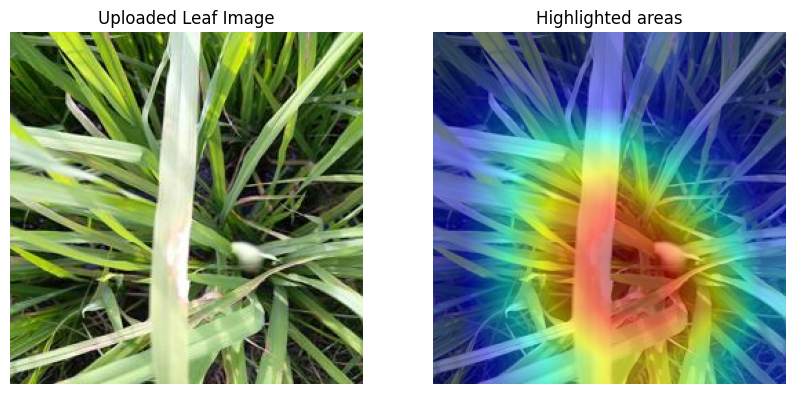

In [62]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import files


IMG_SIZE = 224
NUM_CLASSES = 13
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

CLASS_MAP = {
    "bacterial_leaf_blight": "Bacterial Leaf Blight (ব্যাকটেরিয়াল লিফ ব্লাইট - BLB)",
    "bacterial_leaf_streak": "Bacterial Leaf Streak (ব্যাকটেরিয়াল লিফ স্ট্রিক - BLS)",
    "bacterial_panicle_blight": "Bacterial Panicle Blight (ব্যাকটেরিয়াল প্যানিকল ব্লাইট - BPB)",
    "black_stem_borer": "Black Stem Borer (ব্ল্যাক স্টেম বোরার - BSB)",
    "blast": "Blast (ব্লাস্ট)",
    "brown_spot": "Brown Spot (ব্রাউন স্পট)",
    "downy_mildew": "Downy Mildew (ডাউনি মিলডিউ)",
    "hispa": "Hispa (হিসপা)",
    "leaf_roller": "Leaf Roller (লিফ রোলার)",
    "normal": "Normal (স্বাভাবিক অবস্থা)",
    "tungro": "Tungro (টংগ্রো)",
    "white_stem_borer": "White Stem Borer (হোয়াইট স্টেম বোরার)",
    "yellow_stem_borer": "Yellow Stem Borer (ইয়েলো স্টেম বোরার)"
}

class_idx_to_folder = list(CLASS_MAP.keys())

# rule-based

rule_based = {
    "Bacterial Leaf Blight (ব্যাকটেরিয়াল লিফ ব্লাইট - BLB)": {
        "summary_en": "BLB is a bacterial disease causing water-soaked lesions that enlarge and turn yellow or brown.",
        "summary_bn": "বিএলবি একটি ব্যাকটেরিয়াজনিত রোগ যা পানিভেজা দাগ সৃষ্টি করে যা পরে বড় হয়ে হলুদ বা বাদামী রঙ ধারণ করে।",
        "recommendation_en": "Use resistant varieties, avoid early high nitrogen, apply copper-based bactericides as recommended by agricultural extension. Improve drainage and avoid overhead irrigation.",
        "recommendation_bn": "প্রতিরোধী জাত ব্যবহার করুন, শুরুর দিকে উচ্চ মাত্রায় নাইট্রোজেন প্রয়োগ এড়িয়ে চলুন, কৃষি সম্প্রসারণ অধিদপ্তরের পরামর্শ অনুযায়ী তামা-ভিত্তিক ব্যাকটেরিসাইড ব্যবহার করুন। পানি নিষ্কাশন উন্নত করুন এবং উপরি সেচ পরিহার করুন।",
        "references": [
            "IRRI - Rice Knowledge Bank: Bacterial Leaf Blight",
            "FAO / National Agricultural Extension Recommendations"
        ]
    },
    "Bacterial Leaf Streak (ব্যাকটেরিয়াল লিফ স্ট্রিক - BLS)": {
        "summary_en": "BLS causes narrow, elongated water-soaked streaks on leaves.",
        "summary_bn": "বিএলএস পাতায় সরু, লম্বা ও পানিভেজা দাগ সৃষ্টি করে।",
        "recommendation_en": "Use certified seed, practice crop rotation, remove infected residues, and follow chemical control guidelines from local extension services.",
        "recommendation_bn": "প্রমাণিত বীজ ব্যবহার করুন, ফসল পর্যায় পরিবর্তন করুন, আক্রান্ত অবশিষ্টাংশ সরিয়ে ফেলুন এবং স্থানীয় সম্প্রসারণ অধিদপ্তরের রাসায়নিক ব্যবস্থাপনা নির্দেশিকা অনুসরণ করুন।",
        "references": ["IRRI / FAO resources"]
    },
    "Bacterial Panicle Blight (ব্যাকটেরিয়াল প্যানিকল ব্লাইট - BPB)": {
        "summary_en": "BPB affects panicles causing discoloration and sterility.",
        "summary_bn": "বিপিবি শীষে আক্রমণ করে, যার ফলে বিবর্ণতা এবং বন্ধ্যত্ব দেখা দেয়।",
        "recommendation_en": "Adjust planting dates, use resistant varieties, and consult extension services for management practices.",
        "recommendation_bn": "রোপণের সময় ঠিক করুন, প্রতিরোধী জাত ব্যবহার করুন এবং ব্যবস্থাপনার জন্য কৃষি সম্প্রসারণ থেকে পরামর্শ নিন।",
        "references": ["IRRI / Local Extension Publications"]
    },
    "Black Stem Borer (ব্ল্যাক স্টেম বোরার - BSB)": {
        "summary_en": "Black stem borer damages stems, causing deadhearts or whiteheads.",
        "summary_bn": "ব্ল্যাক স্টেম বোরার গাছের কাণ্ডে আক্রমণ করে, যার ফলে ডেডহার্ট বা হোয়াইটহেড দেখা দেয়।",
        "recommendation_en": "Apply integrated pest management (IPM): biological control, threshold-based insecticide use, and resistant varieties.",
        "recommendation_bn": "সমন্বিত পোকা দমন পদ্ধতি (IPM) ব্যবহার করুন: জৈবিক দমন, নির্ধারিত মাত্রায় কীটনাশক প্রয়োগ এবং প্রতিরোধী জাত ব্যবহার করুন।",
        "references": ["IRRI - Stem Borers", "Local Extension Papers"]
    },
    "Blast (ব্লাস্ট)": {
        "summary_en": "Rice blast causes diamond-shaped lesions with gray centers on leaves.",
        "summary_bn": "ব্লাস্ট রোগ পাতায় ধূসর কেন্দ্রবিশিষ্ট হীরার মতো আকৃতির দাগ সৃষ্টি করে।",
        "recommendation_en": "Use resistant cultivars, avoid dense planting, manage nitrogen levels, and apply fungicides as per guidance.",
        "recommendation_bn": "প্রতিরোধী জাত ব্যবহার করুন, ঘন রোপণ এড়িয়ে চলুন, নাইট্রোজেন ব্যবস্থাপনা করুন এবং নির্দেশনা অনুযায়ী ছত্রাকনাশক প্রয়োগ করুন।",
        "references": ["IRRI - Rice Blast Pages"]
    },
    "Brown Spot (ব্রাউন স্পট)": {
        "summary_en": "Brown spot causes small, round lesions often due to nutrient deficiencies like potassium or silicon.",
        "summary_bn": "ব্রাউন স্পট রোগে সাধারণত পটাশিয়াম বা সিলিকনের ঘাটতির কারণে ছোট গোল দাগ দেখা যায়।",
        "recommendation_en": "Improve soil fertility, use balanced fertilizer, and apply fungicides if recommended.",
        "recommendation_bn": "মাটির উর্বরতা বাড়ান, সুষম সার ব্যবহার করুন এবং প্রয়োজনে ছত্রাকনাশক ব্যবহার করুন।",
        "references": ["IRRI / FAO Publications"]
    },
    "Downy Mildew (ডাউনি মিলডিউ)": {
        "summary_en": "Downy mildew causes yellow patches and fuzzy fungal growth under the leaf surface.",
        "summary_bn": "ডাউনি মিলডিউ পাতার নিচে হলুদ দাগ এবং ছত্রাকের ঝাঁঝালো বৃদ্ধি ঘটায়।",
        "recommendation_en": "Use certified seeds, control humidity, adjust sowing dates, and apply foliar fungicides if needed.",
        "recommendation_bn": "প্রমাণিত বীজ ব্যবহার করুন, আর্দ্রতা নিয়ন্ত্রণ করুন, বপনের সময় ঠিক করুন এবং প্রয়োজনে ছত্রাকনাশক প্রয়োগ করুন।",
        "references": ["IRRI / Extension Guidance"]
    },
    "Hispa (হিসপা)": {
        "summary_en": "Hispa beetle scrapes the leaf surface causing silvery patches.",
        "summary_bn": "হিসপা পোকা পাতার উপরিভাগ চেঁছে রূপালি দাগ সৃষ্টি করে।",
        "recommendation_en": "Use IPM: monitor regularly, conserve natural predators, and apply insecticides if thresholds are exceeded.",
        "recommendation_bn": "IPM অনুসরণ করুন: নিয়মিত পর্যবেক্ষণ করুন, প্রাকৃতিক শত্রু সংরক্ষণ করুন এবং প্রয়োজনে কীটনাশক প্রয়োগ করুন।",
        "references": ["IRRI / Local Insect Pest Manuals"]
    },
    "Leaf Roller (লিফ রোলার)": {
        "summary_en": "Leaf roller larvae roll and feed inside folded leaves.",
        "summary_bn": "লিফ রোলার লার্ভা পাতাকে গুটিয়ে তার ভিতরে খাওয়াদাওয়া করে।",
        "recommendation_en": "Apply biological control, pheromone traps, and insecticides as needed.",
        "recommendation_bn": "জৈবিক দমন, ফেরোমন ফাঁদ এবং প্রয়োজনে কীটনাশক ব্যবহার করুন।",
        "references": ["IRRI / Pest Management Resources"]
    },
    "Normal (স্বাভাবিক অবস্থা)": {
        "summary_en": "No visible disease symptoms detected.",
        "summary_bn": "কোনও রোগের লক্ষণ দেখা যায়নি।",
        "recommendation_en": "No action required. Continue regular monitoring and good agricultural practices.",
        "recommendation_bn": "কোনো ব্যবস্থা প্রয়োজন নেই। নিয়মিত পর্যবেক্ষণ ও ভালো কৃষি অনুশীলন চালিয়ে যান।",
        "references": ["FAO Resources"]
    },
    "Tungro (টংগ্রো)": {
        "summary_en": "Tungro is a viral disease causing stunting and yellow-orange leaf discoloration.",
        "summary_bn": "টংগ্রো একটি ভাইরাসজনিত রোগ যা গাছের বৃদ্ধি বন্ধ এবং পাতায় হলুদ-কমলা বিবর্ণতা সৃষ্টি করে।",
        "recommendation_en": "Control the green leafhopper vector, use resistant varieties, remove infected plants, and use certified seeds.",
        "recommendation_bn": "গ্রিন লিফহপার নিয়ন্ত্রণ করুন, প্রতিরোধী জাত ব্যবহার করুন, আক্রান্ত গাছ অপসারণ করুন এবং প্রমাণিত বীজ ব্যবহার করুন।",
        "references": ["IRRI - Tungro Resources"]
    },
    "White Stem Borer (হোয়াইট স্টেম বোরার)": {
        "summary_en": "White stem borer larvae bore into stems causing deadhearts and whiteheads.",
        "summary_bn": "হোয়াইট স্টেম বোরারের লার্ভা গাছের কাণ্ডে প্রবেশ করে ডেডহার্ট ও হোয়াইটহেড তৈরি করে।",
        "recommendation_en": "Apply IPM techniques: light traps, biological control, and insecticides as per local guidelines.",
        "recommendation_bn": "IPM পদ্ধতি অনুসরণ করুন: আলোর ফাঁদ, জৈবিক দমন এবং স্থানীয় নির্দেশনা অনুযায়ী কীটনাশক প্রয়োগ করুন।",
        "references": ["IRRI / Extension Manuals"]
    },
    "Yellow Stem Borer (ইয়েলো স্টেম বোরার)": {
        "summary_en": "Yellow stem borer causes similar damage to white stem borer, with stunting and deadhearts.",
        "summary_bn": "ইয়েলো স্টেম বোরার হোয়াইট স্টেম বোরারের মতো ক্ষতি করে — গাছের বৃদ্ধি কমে যায় এবং ডেডহার্ট হয়।",
        "recommendation_en": "Use resistant varieties, maintain field sanitation, treat seeds, and follow IPM strategies.",
        "recommendation_bn": "প্রতিরোধী জাত ব্যবহার করুন, ক্ষেত পরিষ্কার রাখুন, বীজ প্রক্রিয়াজাত করুন এবং IPM কৌশল অনুসরণ করুন।",
        "references": ["IRRI / Local Sources"]
    }
}


# device & model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet34(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
state_dict_path = "/content/drive/MyDrive/plantsnap_resnet34/plantSnap_res34_state_dict.pth"
model.load_state_dict(torch.load(state_dict_path, map_location=device))
model = model.to(device)
model.eval()

# transform for model input
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def __call__(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()
        loss = output[0, class_idx]
        loss.backward(retain_graph=True)
        pooled_grads = torch.mean(self.gradients, dim=(2,3), keepdim=True)
        weighted_activations = self.activations * pooled_grads
        cam = weighted_activations.sum(dim=1, keepdim=True)
        cam = torch.clamp(cam, min=0)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

grad_cam = GradCAM(model, model.layer4)

# overlay Grad-CAM
def overlay_cam_on_original(img_pil, cam, alpha=0.5):
    img_np = np.array(img_pil).astype(np.float32)/255.0
    orig_h, orig_w = img_np.shape[:2]
    heatmap = cv2.resize(cam, (orig_w, orig_h))
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)/255.0
    overlay = heatmap*alpha + img_np*(1-alpha)
    overlay = overlay / overlay.max()
    return img_np, overlay

def predict_and_show(img_path):
    img_pil = Image.open(img_path).convert('RGB')
    input_tensor = transform(img_pil).unsqueeze(0).to(device)

    # prediction
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1).squeeze(0).cpu().numpy()

    top_idx = probs.argmax()
    conf = probs[top_idx]
    folder = class_idx_to_folder[top_idx]
    display_name = CLASS_MAP[folder]

    print(f"\nDetected Condition: {display_name}")
    print(f"Confidence: {conf*100:.2f}%")

    # diagnosis details
    diagnosis = rule_based.get(display_name, {})
    summary_en = diagnosis.get("summary_en", "No summary available.")
    summary_bn = diagnosis.get("summary_bn", "")
    recommendation_en = diagnosis.get("recommendation_en", "No recommendation available.")
    recommendation_bn = diagnosis.get("recommendation_bn", "")
    references = diagnosis.get("references", [])

    print(f"\nSummary: {summary_en} ({summary_bn})")
    print(f"\nRecommendation: {recommendation_en} ({recommendation_bn})")

    if references:
        print("\nReferences:")
        for ref in references:
            print(f"- {ref}")

    # grad-CAM visualization
    cam = grad_cam(input_tensor, top_idx)
    orig_img, overlay = overlay_cam_on_original(img_pil, cam)

    print("\nThe highlighted map below shows the areas the plantSnap focused on during prediction:\n")

    # display original and CAM overlay
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_img)
    plt.axis('off')
    plt.title("Uploaded Leaf Image")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(f"Highlighted areas")
    plt.show()


# file upload
uploaded = files.upload()
for fname in uploaded.keys():
    print("Uploaded:", fname)
    predict_and_show(fname)
